<a href="https://colab.research.google.com/github/YuanGongND/ast/blob/master/colab/AST_Inference_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [AST: Audio Spectrogram Transformer](https://www.isca-speech.org/archive/interspeech_2021/gong21b_interspeech.html)

This colab script contains the implementation of a minimal demo of pretrained Audio Spectrogram Transformer (AST) inference and attention visualization.

This script is self-contained and can be run in one click, replace the `sample_audio_path` to test your own audio.

Please cite our paper if you find this repository useful.

```
@inproceedings{gong21b_interspeech,
  author={Yuan Gong and Yu-An Chung and James Glass},
  title={{AST: Audio Spectrogram Transformer}},
  year=2021,
  booktitle={Proc. Interspeech 2021},
  pages={571--575},
  doi={10.21437/Interspeech.2021-698}
}
```
For more information, please check https://github.com/YuanGongND/ast

## Step 1. Install and import required packages.

In [1]:
import sys
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !git clone https://github.com/YuanGongND/ast
    sys.path.append('./ast')
%cd ../

! pip install timm==0.4.5
! pip install wget
import os, csv, argparse, wget
os.environ['TORCH_HOME'] = '../pretrained_models'
if os.path.exists('../pretrained_models') == False:
  os.mkdir('../pretrained_models')
import torch, torchaudio, timm
import numpy as np
from torch.cuda.amp import autocast
import IPython

/Users/avtar/miniconda3/envs/l3d_2024f_cpu/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/Users/avtar/Library/CloudStorage/OneDrive-Tufts/Tufts CS/CS152 L3D/Project/Code/audioSet-Pretrained


## Step 2. Create AST model and load AudioSet pretrained weights.
The pretrained model achieves 45.93 mAP on the AudioSet evaluation set, which is the best single model in the paper. 

In [50]:
import sys
sys.path.append('../')
from src.models import ASTModel

# Create a new class that inherits the original ASTModel class
class ASTModelVis(ASTModel):
    def get_att_map(self, block, x):
        qkv = block.attn.qkv
        num_heads = block.attn.num_heads
        scale = block.attn.scale
        B, N, C = x.shape
        qkv = qkv(x).reshape(B, N, 3, num_heads, C // num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)
        attn = (q @ k.transpose(-2, -1)) * scale
        attn = attn.softmax(dim=-1)
        return attn

    def forward_visualization(self, x):
        # expect input x = (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        x = x.unsqueeze(1)
        x = x.transpose(2, 3)

        B = x.shape[0]
        x = self.v.patch_embed(x)
        cls_tokens = self.v.cls_token.expand(B, -1, -1)
        dist_token = self.v.dist_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, dist_token, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)
        # save the attention map of each of 12 Transformer layer
        att_list = []
        for blk in self.v.blocks:
            cur_att = self.get_att_map(blk, x)
            att_list.append(cur_att)
            x = blk(x)
        return att_list

def make_features(wav_name, mel_bins, target_length=1024):
    waveform, sr = torchaudio.load(wav_name)
    # assert sr == 16000, 'input audio sampling rate must be 16kHz'

    fbank = torchaudio.compliance.kaldi.fbank(
        waveform, htk_compat=True, sample_frequency=sr, use_energy=False,
        window_type='hanning', num_mel_bins=mel_bins, dither=0.0, frame_shift=10)

    n_frames = fbank.shape[0]

    print(f'[*INFO] {wav_name} has {n_frames} frames')
    print(f'[*INFO] {wav_name} has dimensions {fbank.shape} and type {fbank.dtype}')

    # Compute the mel scale values for each bin
    mel_scale = np.linspace(0, 2595 * np.log10(1 + sr / 2 / 700), mel_bins)
    # Convert mel scale values back to frequency scale
    freq_scale = 700 * (10**(mel_scale / 2595) - 1)
    print(f'Frequency values for each mel bin: {freq_scale}')
    # Select 8 evenly spaced indices from the freq_scale array
    num_ticks = 8
    tick_indices = np.linspace(0, mel_bins - 1, num_ticks, dtype=int)
    tick_freqs = freq_scale[tick_indices]
    
    import matplotlib.pyplot as plt

    plt.imshow(fbank.T, aspect='auto', origin='lower')
    # plt.title('Mel Spectrogram')
    plt.xlabel('Time [s]')
    plt.ylabel('Frequency [Hz]')
    plt.colorbar(format='%+2.0f dB')

    # Set the y-ticks to the selected frequency values
    plt.yticks(tick_indices, [f'{freq:.0f}' for freq in tick_freqs])
    # Set the x-ticks to be 1/100th of their value
    x_ticks = np.linspace(0, n_frames - 1, num_ticks, dtype=int)
    x_tick_labels = [f'{x/100:.0f}' for x in x_ticks]
    plt.xticks(x_ticks, x_tick_labels)
    
    plt.show()
    
    print(f'fbank min: {fbank.min()}, fbank max: {fbank.max()}')
    
    p = target_length - n_frames
    if p > 0:
        m = torch.nn.ZeroPad2d((0, 0, 0, p))
        fbank = m(fbank)
    elif p < 0:
        fbank = fbank[0:target_length, :]

    fbank = (fbank - (-4.2677393)) / (4.5689974 * 2)
    return fbank


def load_label(label_csv):
    with open(label_csv, 'r') as f:
        reader = csv.reader(f, delimiter=',')
        lines = list(reader)
    labels = []
    ids = []  # Each label has a unique id such as "/m/068hy"
    for i1 in range(1, len(lines)):
        id = lines[i1][1]
        label = lines[i1][2]
        ids.append(id)
        labels.append(label)
    return labels

# Create an AST model and download the AudioSet pretrained weights
audioset_mdl_url = 'https://www.dropbox.com/s/cv4knew8mvbrnvq/audioset_0.4593.pth?dl=1'
if os.path.exists('../pretrained_models/audio_mdl.pth') == False:
  wget.download(audioset_mdl_url, out='../pretrained_models/audio_mdl.pth')

# Assume each input spectrogram has 1024 time frames
input_tdim = 1024
checkpoint_path = '../pretrained_models/audio_mdl.pth'
# now load the visualization model
ast_mdl = ASTModelVis(label_dim=527, input_tdim=input_tdim, imagenet_pretrain=False, audioset_pretrain=False)
print(f'[*INFO] load checkpoint: {checkpoint_path}')
checkpoint = torch.load(checkpoint_path, map_location=torch.device('mps'))
audio_model = torch.nn.DataParallel(ast_mdl, device_ids=[0])
audio_model.load_state_dict(checkpoint)
audio_model = audio_model.to(torch.device("mps"))
audio_model.eval()          

# Load the AudioSet label set
# label_csv = '../egs/audioset/data/class_labels_indices.csv'       # label and indices for audioset data
# labels = load_label(label_csv)

---------------AST Model Summary---------------
ImageNet pretraining: False, AudioSet pretraining: False
frequncey stride=10, time stride=10
number of patches=1212
[*INFO] load checkpoint: ../pretrained_models/audio_mdl.pth


/var/folders/md/s3kx95_13hb51505hrc358j00000gn/T/ipykernel_97841/3499541241.py:115: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, ma

DataParallel(
  (module): ASTModelVis(
    (v): DistilledVisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (blocks): ModuleList(
        (0-11): 12 x Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (act): GELU(approximate='none')
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
            (drop): 

## Step 3. Load an audio and predict the sound class.
By default we test one sample from another dataset (VGGSound) that has not been seen during the model training.

For this very specific sample, it is a parrot mimicing human speech and there's a bird chirp in the middle, that's why the model predicts it is a mixture of speech and bird sound. This audio is extracted from a Youtube video, and the video looks like this (note: only audio is used for prediction): 

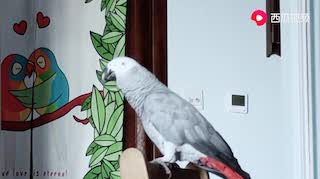

Replace the `sample_audio_path` to test your own audio.

[*INFO] Data/Audio/greegr/XC663143.ogg has 1032 frames
[*INFO] Data/Audio/greegr/XC663143.ogg has dimensions torch.Size([1032, 128]) and type torch.float32
Frequency values for each mel bin: [    0.            17.70410334    35.85597135    54.46692872
    73.54858654    93.11284955   113.17192362   133.73832329
   154.82487962   176.4447482    198.61141733   221.33871646
   244.64082481   268.53228021   293.02798817   318.1432312
   343.89367831   370.29539481   397.36485234   425.11893912
   453.5749705    482.75069976   512.66432921   543.33452149
   574.78041127   607.02161718   640.078254     673.97094527
   708.72083612   744.34960649   780.87948461   818.33326094
   856.7343023    896.10656652   936.47461736   977.86363984
  1020.29945593  1063.8085407   1108.41803881  1154.15578143
  1201.05030365  1249.13086226  1298.42745398  1348.9708342
  1400.79253618  1453.92489068  1508.40104617  1564.25498951
  1621.5215671   1680.2365067   1740.43643968  1802.15892384
  1865.44246692  1

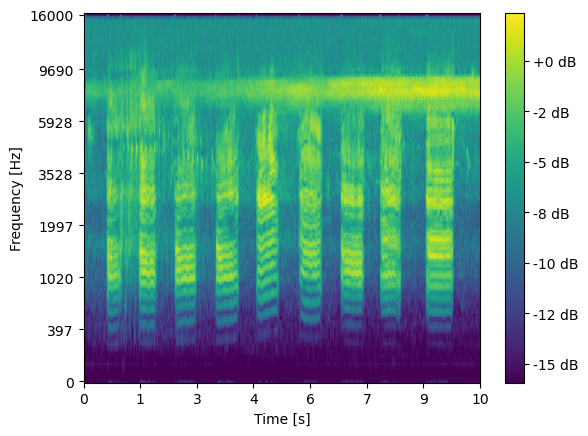

fbank min: -15.942384719848633, fbank max: 2.3648486137390137


/var/folders/md/s3kx95_13hb51505hrc358j00000gn/T/ipykernel_97841/2733291078.py:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/Users/avtar/miniconda3/envs/l3d_2024f_cpu/lib/python3.12/site-packages/torch/amp/autocast_mode.py:265: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Predice results:


NameError: name 'labels' is not defined

In [51]:
# Get a sample audio and make feature for predict
# change url to play with the script
#sample_audio_path = 'https://www.dropbox.com/s/kx8s8irzwj6nbeq/glLQrEijrKg_000300.flac?dl=1'

# # some other samples
sample_audio_path = 'https://www.dropbox.com/s/vddohcnb9ane9ag/LDoXsip0BEQ_000177.flac?dl=1'
#sample_audio_path = 'https://www.dropbox.com/s/omned2muw8cyunf/6jiO0tPLK7U_000090.flac?dl=1'

if os.path.exists('../sample_audios') == False:
  os.mkdir('../sample_audios')
if os.path.exists('../sample_audios/sample_audio.flac') == True:
  os.remove('../sample_audios/sample_audio.flac')
wget.download(sample_audio_path, '../sample_audios/sample_audio.flac')
# XC37740.ogg
# feats = make_features('Data/Audio/grewar3/XC342323.ogg', mel_bins=128)           # shape(1024, 128)
feats = make_features('Data/Audio/greegr/XC663143.ogg', mel_bins=128)           # shape(1024, 128)
# feats = make_features('Data/Audio/greegr/XC497808.ogg', mel_bins=128)           # shape(1024, 128)
# feats = make_features('../sample_audios/XC53987.ogg', mel_bins=128)           # shape(1024, 128)

# from PIL import Image
# import torchvision.transforms as transforms
# # Load the image
# image = Image.open("../sample_audios/XC25894_10.png")  # Convert to grayscale
# display(image)

# # Convert to a PyTorch tensor
# transform = transforms.ToTensor()
# feats = transform(image)

feats_data = feats.expand(1, input_tdim, 128)           # reshape the feature
feats_data = feats_data.to(torch.device("mps"))
# do some masking of the input
#feats_data[:, :512, :] = 0.

# Make the prediction
with torch.no_grad():
  with autocast():
    output = audio_model.forward(feats_data)
    output = torch.sigmoid(output)
result_output = output.data.cpu().numpy()[0]
sorted_indexes = np.argsort(result_output)[::-1]

# Print audio tagging top probabilities
print('Predice results:')
for k in range(10):
    print('- {}: {:.4f}'.format(np.array(labels)[sorted_indexes[k]], result_output[sorted_indexes[k]]))
print('Listen to this sample: ')
IPython.display.Audio('../sample_audios/sample_audio.flac')

## Step 4.a. Visualize the mean attention map of all attention heads for each layer
Note the model focuses on the middle high frequency bird chirp as well as the low frequency speech.

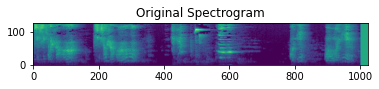

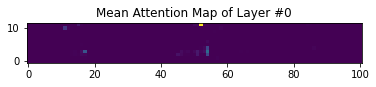

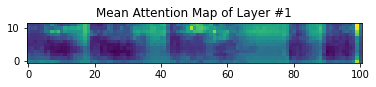

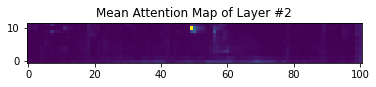

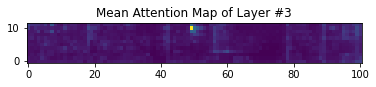

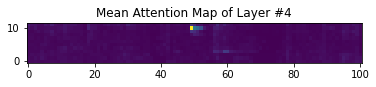

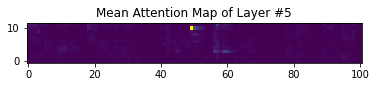

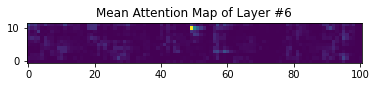

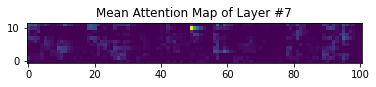

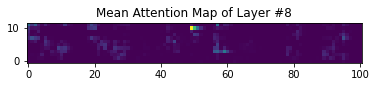

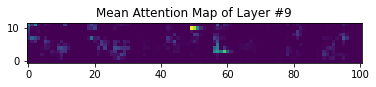

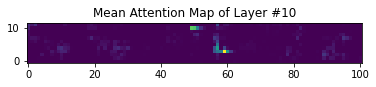

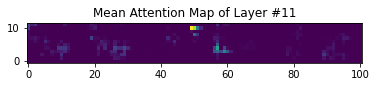

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(feats_data[0].t().cpu(), origin='lower')
plt.title('Original Spectrogram')
plt.show()
plt.close()
# Make the prediction
with torch.no_grad():
  with autocast():
    att_list = audio_model.module.forward_visualization(feats_data)
for i in range(len(att_list)):
  att_list[i] = att_list[i].data.cpu().numpy()
  att_list[i] = np.mean(att_list[i][0], axis=0)
  att_list[i] = np.mean(att_list[i][0:2], axis=0)
  att_list[i] = att_list[i][2:].reshape(12, 101)
  plt.imshow(att_list[i], origin='lower')
  plt.title('Mean Attention Map of Layer #{:d}'.format(i))
  plt.show()
  plt.close()

## Step 4.b. Visualize the attention map of each attention head of a specific layer
Note the attention map of heads are quite diverse.

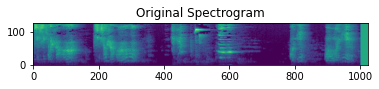

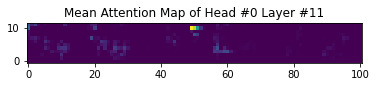

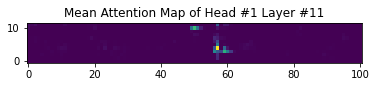

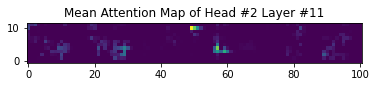

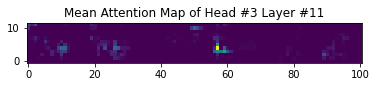

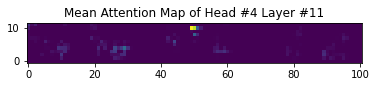

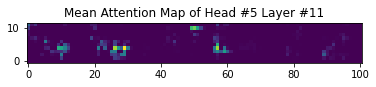

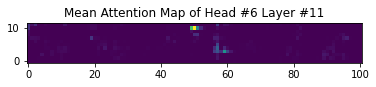

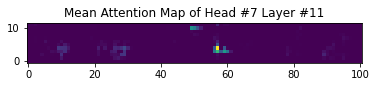

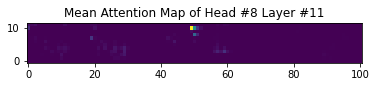

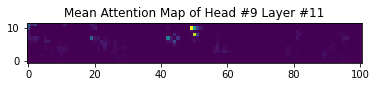

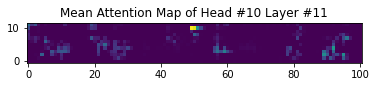

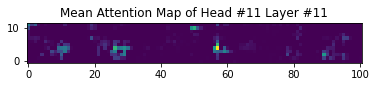

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(feats_data[0].t().cpu(), origin='lower')
plt.title('Original Spectrogram')
plt.show()
plt.close()
# Make the prediction
with torch.no_grad():
  with autocast():
    att_list = audio_model.module.forward_visualization(feats_data)

# the layer of interest
i = 11

att_map = att_list[i].data.cpu().numpy()
att_map = att_map[0]
att_map = np.mean(att_map[:, 0:2, :], axis=1)
att_map = att_map[:, 2:].reshape(12, 12, 101)
for j in range(12):
  plt.imshow(att_map[j], origin='lower')
  plt.title('Mean Attention Map of Head #{:d} Layer #{:d}'.format(j, i))
  plt.show()
  plt.close()